In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import json
import random
import cv2
import pickle
import numpy as np
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
import torch
import tqdm
device = "cuda:3" if torch.cuda.is_available() else "cpu"
random.seed(41)

In [3]:
max_dim = 2000
min_dim = 600

def getFrontCutout(masks,image):
    frontMask = None
    if len(masks) == 0:
        return frontMask
    elif len(masks) == 1:
        frontMask = masks[0]
    elif len(masks) == 2:
        if masks[0]['bbox'][0] <=5 and masks[0]['bbox'][1] <=5:
            #masks[0] is background, return 1
            frontMask = masks[1]
        else:
            #choose between 0 or 1
            if masks[0]['area'] > masks[1]['area']*1.5: #masks[1] is much bigger than masks[2]
                frontMask = masks[0]
            elif masks[0]['bbox'][1] < masks[1]['bbox'][1]:  # ycoordinate of front mask will be smaller
                frontMask = masks[0]
            else:
                frontMask = masks[1]
    else:
        if masks[0]['bbox'][0] <=5 and masks[0]['bbox'][1] <=5:
            #masks[0] is background, choose from 1 or 2
            if masks[1]['area'] > masks[2]['area']*1.5: #masks[1] is much bigger than masks[2]
                frontMask = masks[1]
            elif masks[1]['bbox'][1] < masks[2]['bbox'][1]:  # ycoordinate of front mask will be smaller
                frontMask = masks[1]
            else:
                frontMask = masks[2]

        else:
            #choose between 0 or 1
            if masks[0]['area'] > masks[1]['area']*1.5: #masks[1] is much bigger than masks[2]
                frontMask = masks[0]
            elif masks[0]['bbox'][1] < masks[1]['bbox'][1]:  # ycoordinate of front mask will be smaller
                frontMask = masks[0]
            else:
                frontMask = masks[1]
                
    x,y,w,h = frontMask['bbox']
    x,y,w,h = int(x), int(y), int(w), int(h)
    cutout = image[y:y+h, x:x+w]
    return cutout


def resizeImage(image):
    
    while image.shape[0]/max_dim > 1 or image.shape[1]/max_dim > 1:
        dim = (int(image.shape[1]/2), int(image.shape[0]/2))
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    return image 


def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((np.array(sorted_anns[0]['segmentation']).shape[0], np.array(sorted_anns[0]['segmentation']).shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)



In [6]:
#try segmentation on single image
sam_checkpoint = "/trunk/shared/cuneiform/CuneiformDating/image_classification/segmentation/sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=5,
    pred_iou_thresh=0.94,
    stability_score_thresh=0.90,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=10000,  # Requires open-cv to run post-processing
)

In [ ]:
with open('/trunk/shared/cuneiform/full_data/all_ids.json', 'r') as f:
    all_ids = json.load(f)
    
sampled_imgs = random.sample(all_ids,100)
image_names = ['P' + img.zfill(6) +'.jpg' for img in sampled_imgs]

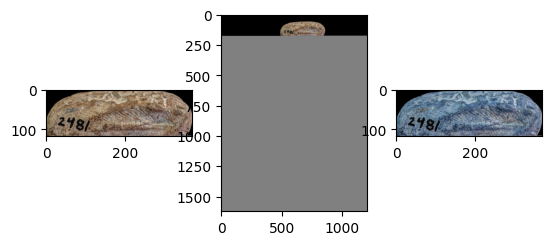

P105905.jpg


In [46]:
pid = 105905

f, axarr = plt.subplots(1,3)
image_path = "/trunk/shared/cuneiform/full_data/images/"+ "P"+ str(pid).zfill(6)+".jpg"
image = cv2.imread(image_path)
image_print = cv2.cvtColor(image, cv2. COLOR_BGR2RGB)
width = image.shape[1]
height = image.shape[0]
    


masks_filepath = "/trunk/shared/cuneiform/full_data/segmented_mask_info_compressed/"+ "P"+ str(pid).zfill(6)+".pkl"
with open (masks_filepath, 'rb') as f:
    masks = pickle.load(f)

cutout = getFrontCutout(masks, image)
cutout = cv2.cvtColor(cutout, cv2. COLOR_BGR2RGB)

actual_cutout = cv2.imread("/trunk/shared/cuneiform/full_data/segmented_images/"+ "P"+ str(pid).zfill(6)+".jpg")

axarr[0].imshow(cutout)
axarr[1].imshow(image_print)
axarr[2].imshow(actual_cutout)
plt.show()
print("P"+ str(pid).zfill(6)+".jpg")

# cv2.imwrite("/trunk/shared/cuneiform/full_data/segmented_images/"+ "P"+ str(pid).zfill(6)+".jpg", cutout)

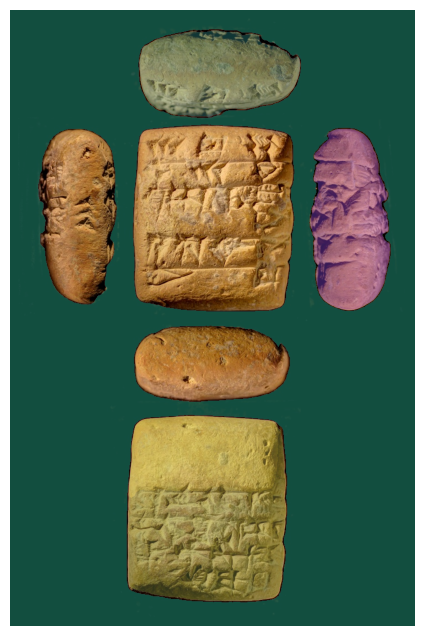

In [40]:
plt.figure(figsize=(8,8))
plt.imshow(image_print)
show_anns(masks[:5])
plt.axis('off')
plt.show() 

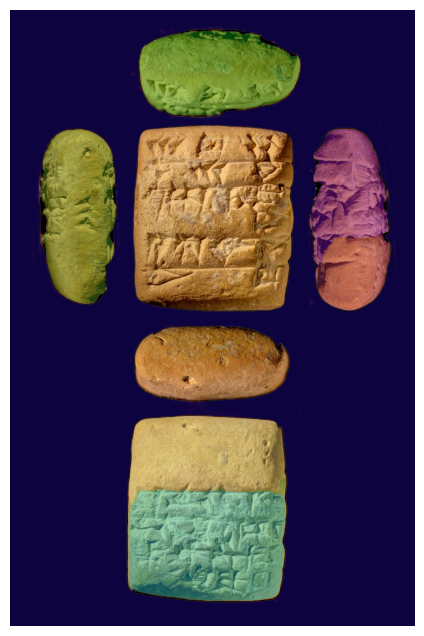

In [41]:
new_masks = mask_generator.generate(image)
new_masks = sorted(new_masks, key = lambda d: d['area'], reverse = True)
plt.figure(figsize=(8,8))
plt.imshow(image_print)
show_anns(new_masks)
plt.axis('off')
plt.show() 

621 621


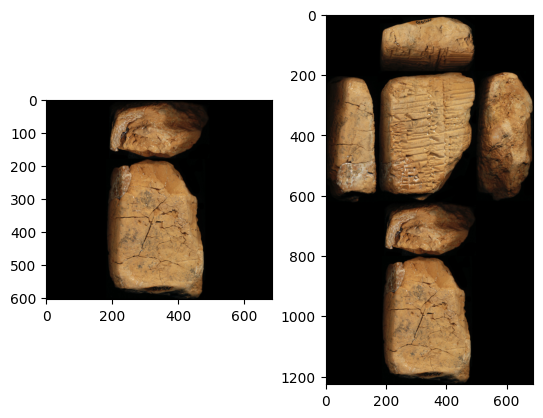

High Resolution, new segmentation
P229535.jpg


In [16]:
for pid in [229535]:
    f, axarr = plt.subplots(1,2)
    image_path = "../../../full_data/images/"+ "P"+ str(pid).zfill(6)+".jpg"
    image = cv2.imread(image_path)
    image_print = cv2.cvtColor(image, cv2. COLOR_BGR2RGB)
    width = image.shape[1]
    height = image.shape[0]
    
    #if very high resolution image, then resize, run segmentation, save cutout and masks
    if height>max_dim or width>max_dim:
        image = resizeImage(image)
        image_print = cv2.cvtColor(image, cv2. COLOR_BGR2RGB)
        masks = mask_generator.generate(image)
        masks = sorted(masks, key = lambda d: d['area'], reverse = True)
        topFive = masks[:5]
        newFilePath = "../../../full_data/segmented_mask_info_compressed/P" + str(pid).zfill(6) +".pkl"
        with open(newFilePath, 'wb') as f:
            pickle.dump(topFive,f)
        cutout = getFrontCutout(topFive, image)
        cutout = cv2.cvtColor(cutout, cv2. COLOR_BGR2RGB)
        cv2.imwrite("../../../full_data/segmented_images/"+ "P"+ str(pid).zfill(6)+".jpg", cutout)
        axarr[0].imshow(cutout)
        axarr[1].imshow(image_print)
        plt.show()
        print("High Resolution, new segmentation")
        print("P"+ str(pid).zfill(6)+".jpg")


    #if low resolution image, keep as it is
    elif height<=min_dim and width<=min_dim:
        axarr[0].imshow(image_print)
        axarr[1].imshow(image_print)
        plt.show()
        print("Low Resolution kept as it is")
        print("P"+ str(pid).zfill(6)+".jpg")
    
    #use existing masks, but get a new cutout
    else:

        masks_filepath = "../../../full_data/segmented_mask_info_compressed/"+ "P"+ str(pid).zfill(6)+".pkl"
        with open (masks_filepath, 'rb') as f:
            masks = pickle.load(f)
        
        cutout = getFrontCutout(masks, image)
        cutout = cv2.cvtColor(cutout, cv2. COLOR_BGR2RGB)

        axarr[0].imshow(cutout)
        axarr[1].imshow(image_print)
        plt.show()
        print("P"+ str(pid).zfill(6)+".jpg")

In [12]:
image_print.shape

(1265, 720, 3)